# Class 2 - Notebook D: Portfolio Optimization
## Crypto Portfolio Construction & Risk Management

**Topics Covered:**
- Modern Portfolio Theory (MPT) for crypto
- Stablecoin portfolio allocation
- DeFi yield portfolio construction
- Monte Carlo simulations
- Risk metrics: Sharpe, Sortino, Max Drawdown, VaR
- Efficient frontier calculation
- Rebalancing strategies
- Portfolio stress testing

**Homework Assignment**: Students will optimize their own portfolios based on risk preferences

---
## 1. Setup & Imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.optimize import minimize
import requests
import time

warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis date: 2025-11-02 13:28:26


---
## 2. Modern Portfolio Theory Foundations

### Key Concepts:
- **Expected Return**: Mean of historical returns
- **Risk (Volatility)**: Standard deviation of returns
- **Sharpe Ratio**: (Return - Risk_free_rate) / Volatility
- **Sortino Ratio**: Similar to Sharpe but only penalizes downside volatility
- **Efficient Frontier**: Optimal portfolios for each risk level
- **Diversification**: Reduces unsystematic risk through correlation management

---
## 3. Data Fetching: Historical Prices

We'll fetch historical data for multiple asset classes:
- **Crypto Assets**: BTC, ETH, SOL, AVAX, MATIC
- **Stablecoins**: USDT, USDC, DAI
- **DeFi Tokens**: UNI, AAVE, CRV, MKR

In [16]:
# Asset universe for portfolio optimization
PORTFOLIO_ASSETS = {
    'bitcoin': 'BTC',
    'ethereum': 'ETH',
    'solana': 'SOL',
    'avalanche-2': 'AVAX',
    'matic-network': 'MATIC',
    'uniswap': 'UNI',
    'aave': 'AAVE',
    'curve-dao-token': 'CRV',
    'maker': 'MKR'
}

STABLECOINS = {
    'tether': 'USDT',
    'usd-coin': 'USDC',
    'dai': 'DAI'
}

# Risk-free rate (approximate from T-bills)
RISK_FREE_RATE = 0.05  # 5% annual

print(f"Portfolio Assets: {len(PORTFOLIO_ASSETS)}")
print(f"Stablecoins: {len(STABLECOINS)}")

Portfolio Assets: 9
Stablecoins: 3


In [17]:
def fetch_historical_prices_coingecko(coin_id: str, 
                                     days: int = 365,
                                     max_retries: int = 3) -> Optional[pd.DataFrame]:
    """
    Fetch historical daily prices from CoinGecko.
    
    Args:
        coin_id: CoinGecko coin ID
        days: Number of days of historical data
        max_retries: Maximum retry attempts
    
    Returns:
        DataFrame with timestamp and price columns
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days,
        'interval': 'daily'
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                if 'prices' in data:
                    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
                    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
                    df['date'] = df['timestamp'].dt.date
                    return df
            
            elif response.status_code == 429:
                wait_time = (2 ** attempt) * 2
                print(f"Rate limited. Waiting {wait_time}s...")
                time.sleep(wait_time)
            
        except Exception as e:
            print(f"Error fetching {coin_id}: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
    
    return None

print("✅ Historical price fetching function defined")

✅ Historical price fetching function defined


In [18]:
# Fetch historical data for all assets
print("Fetching historical price data (365 days)...\n")

historical_data = {}

for coin_id, symbol in PORTFOLIO_ASSETS.items():
    print(f"Fetching {symbol}...", end=' ')
    df = fetch_historical_prices_coingecko(coin_id, days=365)
    
    if df is not None:
        historical_data[symbol] = df
        print(f"✅ {len(df)} days")
    else:
        print("❌ Failed")
    
    time.sleep(1.5)  # Rate limiting

print(f"\n📊 Successfully fetched data for {len(historical_data)} assets")

Fetching historical price data (365 days)...

Fetching BTC... ✅ 366 days
Fetching ETH... ✅ 366 days
Fetching SOL... ✅ 366 days
Fetching AVAX... ✅ 366 days
Fetching MATIC... ✅ 351 days
Fetching UNI... ✅ 366 days
Fetching AAVE... ✅ 366 days
Fetching CRV... Rate limited. Waiting 2s...
Rate limited. Waiting 4s...
Rate limited. Waiting 8s...
❌ Failed
Fetching MKR... Rate limited. Waiting 2s...
Rate limited. Waiting 4s...
Rate limited. Waiting 8s...
❌ Failed

📊 Successfully fetched data for 7 assets


In [19]:
# Create price matrix (rows = dates, columns = assets)
price_data = pd.DataFrame()

for symbol, df in historical_data.items():
    df_temp = df[['date', 'price']].copy()
    df_temp.columns = ['date', symbol]
    
    if price_data.empty:
        price_data = df_temp
    else:
        price_data = price_data.merge(df_temp, on='date', how='outer')

price_data = price_data.sort_values('date').reset_index(drop=True)
price_data = price_data.dropna()  # Remove dates with missing data

print(f"Price matrix shape: {price_data.shape}")
print(f"Date range: {price_data['date'].min()} to {price_data['date'].max()}")
print(f"\nAssets included: {', '.join(price_data.columns[1:])}")

Price matrix shape: (351, 8)
Date range: 2024-11-03 to 2025-10-18

Assets included: BTC, ETH, SOL, AVAX, MATIC, UNI, AAVE


---
## 4. Calculate Returns & Statistics

In [20]:
# Calculate daily returns
returns_data = price_data.copy()
asset_columns = [col for col in returns_data.columns if col != 'date']

for col in asset_columns:
    returns_data[col] = returns_data[col].pct_change()

# Remove first row (NaN from pct_change)
returns_data = returns_data.iloc[1:].reset_index(drop=True)

print(f"Returns data shape: {returns_data.shape}")
print(f"\nSample returns (first 5 days):")
print(returns_data.head())

Returns data shape: (350, 8)

Sample returns (first 5 days):
         date       BTC       ETH       SOL      AVAX     MATIC       UNI  \
0  2024-11-04 -0.007152 -0.013797 -0.020043 -0.022496 -0.036474 -0.043036   
1  2024-11-05 -0.014683 -0.024840 -0.031111 -0.035608 -0.032869 -0.039836   
2  2024-11-06  0.022747  0.011027  0.056496  0.055182  0.042978  0.058244   
3  2024-11-07  0.090653  0.123125  0.124058  0.127564  0.100674  0.301695   
4  2024-11-08  0.004845  0.064085  0.048267  0.013370  0.032758 -0.044352   

       AAVE  
0 -0.038343  
1 -0.034426  
2  0.055542  
3  0.282349  
4  0.055628  


In [21]:
def calculate_portfolio_statistics(returns_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate comprehensive statistics for each asset.
    
    Returns:
        DataFrame with statistics for each asset
    """
    asset_cols = [col for col in returns_df.columns if col != 'date']
    stats_list = []
    
    for asset in asset_cols:
        returns = returns_df[asset].dropna()
        
        # Annualized metrics (252 trading days)
        mean_return = returns.mean() * 252
        volatility = returns.std() * np.sqrt(252)
        
        # Downside deviation (only negative returns)
        downside_returns = returns[returns < 0]
        downside_std = downside_returns.std() * np.sqrt(252)
        
        # Sharpe and Sortino ratios
        sharpe = (mean_return - RISK_FREE_RATE) / volatility if volatility > 0 else 0
        sortino = (mean_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0
        
        # Max drawdown
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_dd = drawdown.min()
        
        # VaR and CVaR (95% confidence)
        var_95 = returns.quantile(0.05)
        cvar_95 = returns[returns <= var_95].mean()
        
        stats_list.append({
            'Asset': asset,
            'Annual_Return_%': mean_return * 100,
            'Volatility_%': volatility * 100,
            'Downside_Volatility_%': downside_std * 100,
            'Sharpe_Ratio': sharpe,
            'Sortino_Ratio': sortino,
            'Max_Drawdown_%': max_dd * 100,
            'VaR_95_%': var_95 * 100,
            'CVaR_95_%': cvar_95 * 100,
            'Skewness': stats.skew(returns),
            'Kurtosis': stats.kurtosis(returns)
        })
    
    return pd.DataFrame(stats_list)

asset_statistics = calculate_portfolio_statistics(returns_data)
asset_statistics = asset_statistics.sort_values('Sharpe_Ratio', ascending=False)

print("\n📊 Asset Statistics (Sorted by Sharpe Ratio):")
print(asset_statistics.to_string(index=False))

# Filter out assets with invalid statistics (inf, NaN, -100% drawdown)
invalid_assets = asset_statistics[
    (asset_statistics['Annual_Return_%'].isin([np.inf, -np.inf])) |
    (asset_statistics['Volatility_%'].isna()) |
    (asset_statistics['Max_Drawdown_%'] <= -99)
]['Asset'].tolist()

if invalid_assets:
    print(f"\n⚠️  WARNING: Excluding assets with invalid data: {', '.join(invalid_assets)}")
    print(f"   Reason: Infinite returns, NaN volatility, or complete drawdown (-100%)")
    
    # Remove invalid assets from returns data and asset columns
    asset_columns = [col for col in asset_columns if col not in invalid_assets]
    returns_data = returns_data[['date'] + asset_columns].copy()
    asset_statistics = asset_statistics[~asset_statistics['Asset'].isin(invalid_assets)].copy()
    
    print(f"   Continuing with {len(asset_columns)} valid assets: {', '.join(asset_columns)}\n")


📊 Asset Statistics (Sorted by Sharpe Ratio):
Asset  Annual_Return_%  Volatility_%  Downside_Volatility_%  Sharpe_Ratio  Sortino_Ratio  Max_Drawdown_%  VaR_95_%  CVaR_95_%  Skewness  Kurtosis
  BTC        37.774930     37.204871              24.226204      0.880931       1.352871      -28.115010 -3.504661  -4.911863  0.427085  2.809313
  ETH        51.508885     64.536520              40.692470      0.720660       1.142936      -63.360539 -5.654508  -8.447204  0.564687  3.481715
 AAVE        68.474479     90.119171              51.109661      0.704339       1.241927      -67.416516 -7.544182 -10.896853  0.686463  2.965053
  SOL        33.457171     73.587892              45.623784      0.386710       0.623735      -59.824073 -6.598112  -9.341678  0.399369  3.597231
  UNI        28.761685     92.700921              56.072878      0.256326       0.423764      -74.544477 -7.511136 -11.663688  0.793036  4.810358
 AVAX        20.830881     82.552095              55.487503      0.191768     

In [22]:
# Calculate correlation matrix
returns_only = returns_data[asset_columns]
correlation_matrix = returns_only.corr()

print("\n📈 Correlation Matrix:")
print(correlation_matrix.round(3))


📈 Correlation Matrix:
        BTC    ETH    SOL   AVAX    UNI   AAVE
BTC   1.000  0.779  0.768  0.729  0.680  0.656
ETH   0.779  1.000  0.761  0.771  0.815  0.810
SOL   0.768  0.761  1.000  0.715  0.649  0.649
AVAX  0.729  0.771  0.715  1.000  0.744  0.727
UNI   0.680  0.815  0.649  0.744  1.000  0.770
AAVE  0.656  0.810  0.649  0.727  0.770  1.000


---
## 5. VISUALIZATION GROUP 1: Asset Performance & Risk Metrics
### 4 charts showing individual asset characteristics

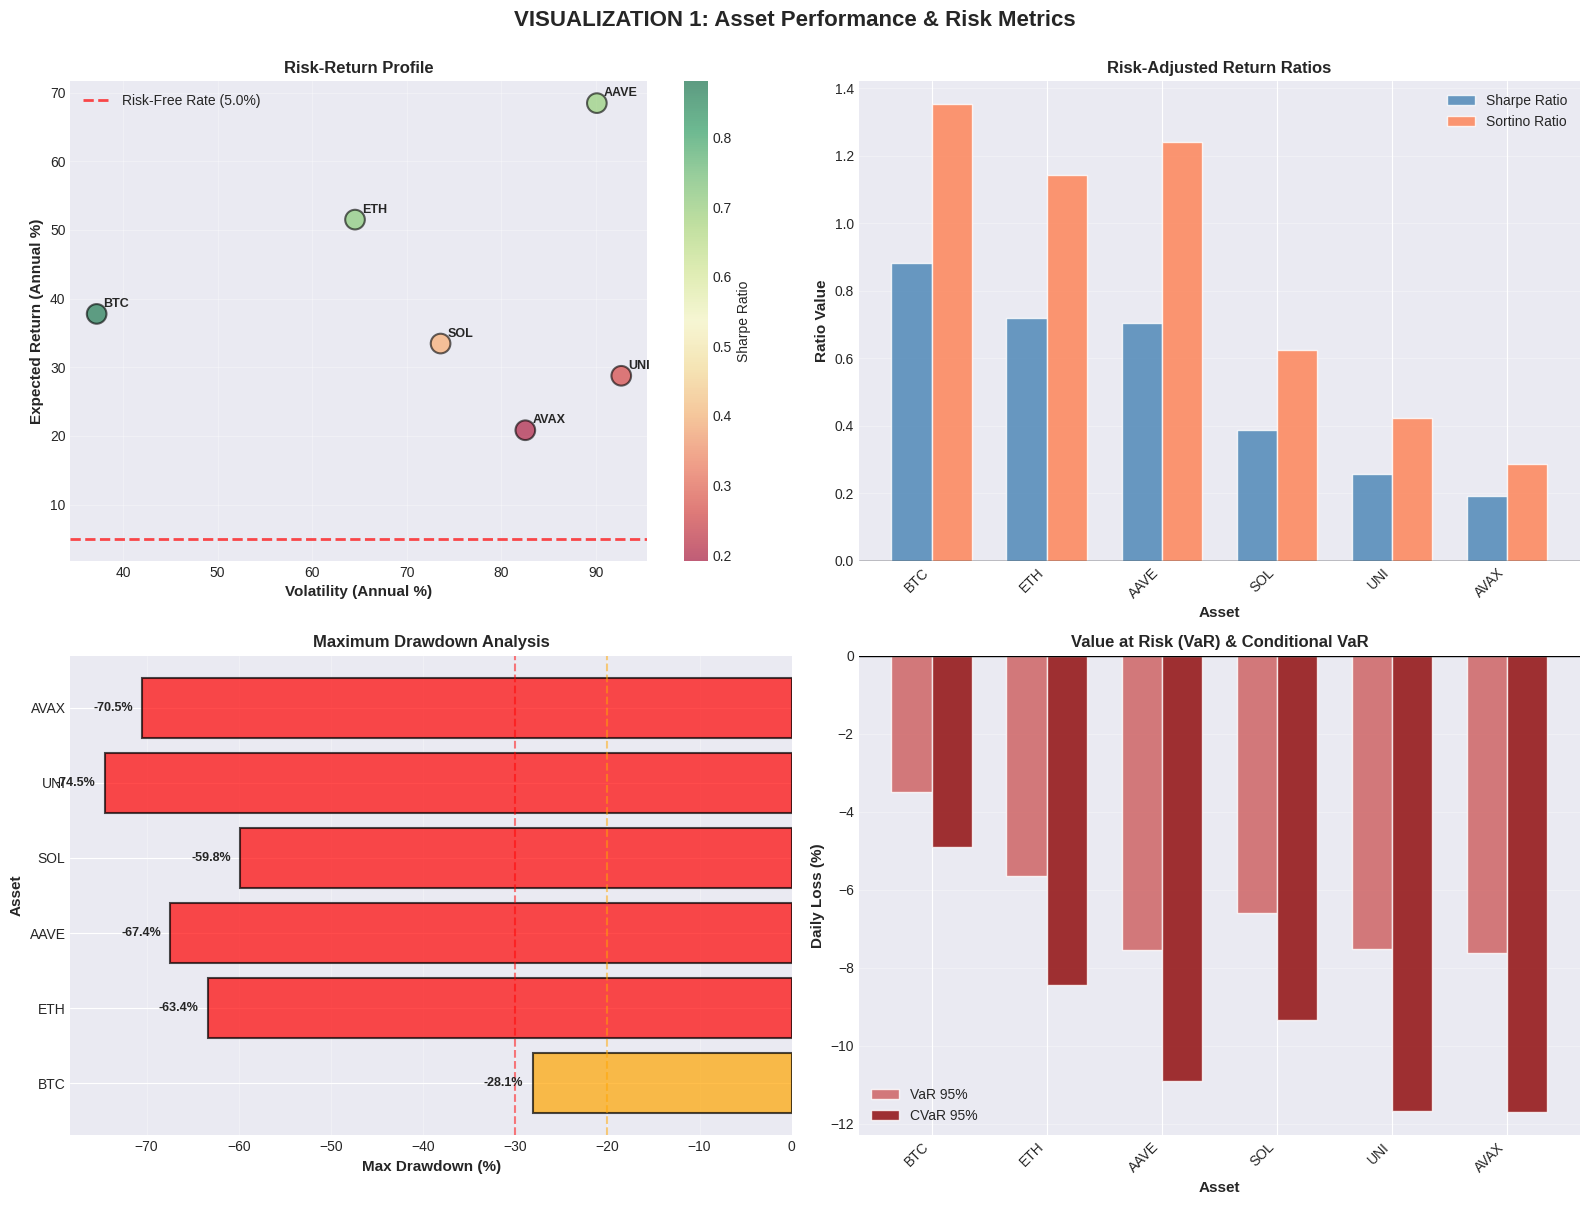


✅ Visualization 1 complete: 4 charts showing asset performance metrics


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VISUALIZATION 1: Asset Performance & Risk Metrics', 
             fontsize=16, fontweight='bold', y=1.00)

# Chart 1: Return vs Volatility
ax1 = axes[0, 0]
scatter = ax1.scatter(asset_statistics['Volatility_%'], 
                     asset_statistics['Annual_Return_%'],
                     s=200, alpha=0.6, c=asset_statistics['Sharpe_Ratio'],
                     cmap='RdYlGn', edgecolors='black', linewidth=1.5)

for idx, row in asset_statistics.iterrows():
    ax1.annotate(row['Asset'], 
                (row['Volatility_%'], row['Annual_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

ax1.axhline(y=RISK_FREE_RATE*100, color='red', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'Risk-Free Rate ({RISK_FREE_RATE*100}%)')
ax1.set_xlabel('Volatility (Annual %)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Expected Return (Annual %)', fontsize=11, fontweight='bold')
ax1.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=ax1)
cbar1.set_label('Sharpe Ratio', fontsize=10)

# Chart 2: Sharpe vs Sortino Ratios
ax2 = axes[0, 1]
x_pos = np.arange(len(asset_statistics))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, asset_statistics['Sharpe_Ratio'], 
               width, label='Sharpe Ratio', alpha=0.8, color='steelblue')
bars2 = ax2.bar(x_pos + width/2, asset_statistics['Sortino_Ratio'], 
               width, label='Sortino Ratio', alpha=0.8, color='coral')

ax2.set_xlabel('Asset', fontsize=11, fontweight='bold')
ax2.set_ylabel('Ratio Value', fontsize=11, fontweight='bold')
ax2.set_title('Risk-Adjusted Return Ratios', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(asset_statistics['Asset'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linewidth=1)

# Chart 3: Maximum Drawdown
ax3 = axes[1, 0]
colors = ['red' if x < -30 else 'orange' if x < -20 else 'green' 
         for x in asset_statistics['Max_Drawdown_%']]
bars = ax3.barh(asset_statistics['Asset'], asset_statistics['Max_Drawdown_%'], 
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.set_xlabel('Max Drawdown (%)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Asset', fontsize=11, fontweight='bold')
ax3.set_title('Maximum Drawdown Analysis', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
ax3.axvline(x=-20, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.axvline(x=-30, color='red', linestyle='--', linewidth=1.5, alpha=0.5)

for i, (bar, val) in enumerate(zip(bars, asset_statistics['Max_Drawdown_%'])):
    ax3.text(val - 1, i, f'{val:.1f}%', 
            va='center', ha='right', fontweight='bold', fontsize=9)

# Chart 4: VaR and CVaR (95% confidence)
ax4 = axes[1, 1]
x_pos = np.arange(len(asset_statistics))
bars1 = ax4.bar(x_pos - width/2, asset_statistics['VaR_95_%'], 
               width, label='VaR 95%', alpha=0.8, color='indianred')
bars2 = ax4.bar(x_pos + width/2, asset_statistics['CVaR_95_%'], 
               width, label='CVaR 95%', alpha=0.8, color='darkred')

ax4.set_xlabel('Asset', fontsize=11, fontweight='bold')
ax4.set_ylabel('Daily Loss (%)', fontsize=11, fontweight='bold')
ax4.set_title('Value at Risk (VaR) & Conditional VaR', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(asset_statistics['Asset'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

print("\n✅ Visualization 1 complete: 4 charts showing asset performance metrics")

---
## 6. Portfolio Optimization Functions

In [24]:
def portfolio_performance(weights: np.ndarray, 
                         mean_returns: np.ndarray,
                         cov_matrix: np.ndarray,
                         risk_free_rate: float = RISK_FREE_RATE) -> Tuple[float, float, float]:
    """
    Calculate portfolio performance metrics.
    
    Args:
        weights: Portfolio weights
        mean_returns: Expected returns for each asset
        cov_matrix: Covariance matrix of returns
        risk_free_rate: Risk-free rate
    
    Returns:
        Tuple of (expected_return, volatility, sharpe_ratio)
    """
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    return portfolio_return, portfolio_volatility, sharpe_ratio


def negative_sharpe(weights: np.ndarray, 
                   mean_returns: np.ndarray, 
                   cov_matrix: np.ndarray,
                   risk_free_rate: float = RISK_FREE_RATE) -> float:
    """
    Return negative Sharpe ratio (for minimization).
    """
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]


def optimize_sharpe_ratio(mean_returns: np.ndarray, 
                         cov_matrix: np.ndarray,
                         risk_free_rate: float = RISK_FREE_RATE) -> Dict:
    """
    Find portfolio with maximum Sharpe ratio.
    
    Returns:
        Dictionary with optimal weights and performance metrics
    """
    num_assets = len(mean_returns)
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: weights between 0 and 1 (no short selling)
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/num_assets] * num_assets)
    
    # Optimize
    result = minimize(negative_sharpe, 
                     initial_weights,
                     args=(mean_returns, cov_matrix, risk_free_rate),
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    
    opt_return, opt_vol, opt_sharpe = portfolio_performance(
        result.x, mean_returns, cov_matrix, risk_free_rate
    )
    
    return {
        'weights': result.x,
        'return': opt_return,
        'volatility': opt_vol,
        'sharpe': opt_sharpe
    }


def optimize_min_volatility(mean_returns: np.ndarray, 
                           cov_matrix: np.ndarray) -> Dict:
    """
    Find minimum volatility portfolio.
    
    Returns:
        Dictionary with optimal weights and performance metrics
    """
    num_assets = len(mean_returns)
    
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array([1/num_assets] * num_assets)
    
    result = minimize(portfolio_volatility,
                     initial_weights,
                     method='SLSQP',
                     bounds=bounds,
                     constraints=constraints)
    
    opt_return, opt_vol, opt_sharpe = portfolio_performance(
        result.x, mean_returns, cov_matrix
    )
    
    return {
        'weights': result.x,
        'return': opt_return,
        'volatility': opt_vol,
        'sharpe': opt_sharpe
    }


def generate_efficient_frontier(mean_returns: np.ndarray,
                               cov_matrix: np.ndarray,
                               num_portfolios: int = 100) -> pd.DataFrame:
    """
    Generate efficient frontier by optimizing for various target returns.
    
    Returns:
        DataFrame with portfolio returns, volatilities, and Sharpe ratios
    """
    num_assets = len(mean_returns)
    
    # Get range of target returns
    min_vol_port = optimize_min_volatility(mean_returns, cov_matrix)
    max_return = np.max(mean_returns)
    target_returns = np.linspace(min_vol_port['return'], max_return, num_portfolios)
    
    results = []
    
    for target in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target}
        )
        bounds = tuple((0, 1) for _ in range(num_assets))
        initial_weights = np.array([1/num_assets] * num_assets)
        
        def portfolio_volatility(weights):
            return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        result = minimize(portfolio_volatility,
                         initial_weights,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        if result.success:
            ret, vol, sharpe = portfolio_performance(result.x, mean_returns, cov_matrix)
            results.append({
                'return': ret,
                'volatility': vol,
                'sharpe': sharpe
            })
    
    return pd.DataFrame(results)

print("✅ Portfolio optimization functions defined")

✅ Portfolio optimization functions defined


---
## 7. Run Portfolio Optimizations

In [25]:
# Prepare data for optimization
returns_matrix = returns_data[asset_columns].values
mean_returns = returns_matrix.mean(axis=0) * 252  # Annualized
cov_matrix = np.cov(returns_matrix.T) * 252  # Annualized

print("Running portfolio optimizations...\n")

# 1. Maximum Sharpe Ratio Portfolio
print("1️⃣ Optimizing for Maximum Sharpe Ratio...")
max_sharpe_portfolio = optimize_sharpe_ratio(mean_returns, cov_matrix)
print(f"   Return: {max_sharpe_portfolio['return']*100:.2f}%")
print(f"   Volatility: {max_sharpe_portfolio['volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {max_sharpe_portfolio['sharpe']:.3f}\n")

# 2. Minimum Volatility Portfolio
print("2️⃣ Optimizing for Minimum Volatility...")
min_vol_portfolio = optimize_min_volatility(mean_returns, cov_matrix)
print(f"   Return: {min_vol_portfolio['return']*100:.2f}%")
print(f"   Volatility: {min_vol_portfolio['volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {min_vol_portfolio['sharpe']:.3f}\n")

# 3. Equal Weight Portfolio (benchmark)
print("3️⃣ Equal Weight Portfolio (Benchmark)...")
equal_weights = np.array([1/len(asset_columns)] * len(asset_columns))
eq_return, eq_vol, eq_sharpe = portfolio_performance(equal_weights, mean_returns, cov_matrix)
equal_weight_portfolio = {
    'weights': equal_weights,
    'return': eq_return,
    'volatility': eq_vol,
    'sharpe': eq_sharpe
}
print(f"   Return: {eq_return*100:.2f}%")
print(f"   Volatility: {eq_vol*100:.2f}%")
print(f"   Sharpe Ratio: {eq_sharpe:.3f}\n")

# 4. Generate Efficient Frontier
print("4️⃣ Generating Efficient Frontier (100 portfolios)...")
efficient_frontier = generate_efficient_frontier(mean_returns, cov_matrix, num_portfolios=100)
print(f"   ✅ Generated {len(efficient_frontier)} efficient portfolios\n")

Running portfolio optimizations...

1️⃣ Optimizing for Maximum Sharpe Ratio...
   Return: 41.19%
   Volatility: 40.36%
   Sharpe Ratio: 0.897

2️⃣ Optimizing for Minimum Volatility...
   Return: 37.77%
   Volatility: 37.20%
   Sharpe Ratio: 0.881

3️⃣ Equal Weight Portfolio (Benchmark)...
   Return: 40.13%
   Volatility: 64.94%
   Sharpe Ratio: 0.541

4️⃣ Generating Efficient Frontier (100 portfolios)...
   ✅ Generated 100 efficient portfolios



In [26]:
# Create allocation DataFrames
portfolio_allocations = pd.DataFrame({
    'Asset': asset_columns,
    'Max_Sharpe_%': max_sharpe_portfolio['weights'] * 100,
    'Min_Volatility_%': min_vol_portfolio['weights'] * 100,
    'Equal_Weight_%': equal_weight_portfolio['weights'] * 100
})

# Filter out assets with < 1% allocation
portfolio_allocations_filtered = portfolio_allocations[
    (portfolio_allocations['Max_Sharpe_%'] >= 1) |
    (portfolio_allocations['Min_Volatility_%'] >= 1) |
    (portfolio_allocations['Equal_Weight_%'] >= 1)
].copy()

print("\n📊 Portfolio Allocations (Assets with >1% weight):")
print(portfolio_allocations_filtered.to_string(index=False))


📊 Portfolio Allocations (Assets with >1% weight):
Asset  Max_Sharpe_%  Min_Volatility_%  Equal_Weight_%
  BTC  8.886539e+01      1.000000e+02       16.666667
  ETH  1.299850e-13      1.942890e-14       16.666667
  SOL  0.000000e+00      0.000000e+00       16.666667
 AVAX  0.000000e+00      0.000000e+00       16.666667
  UNI  0.000000e+00      0.000000e+00       16.666667
 AAVE  1.113461e+01      7.632783e-15       16.666667


---
## 8. VISUALIZATION GROUP 2: Portfolio Allocations & Efficient Frontier
### 4 charts showing optimal portfolios

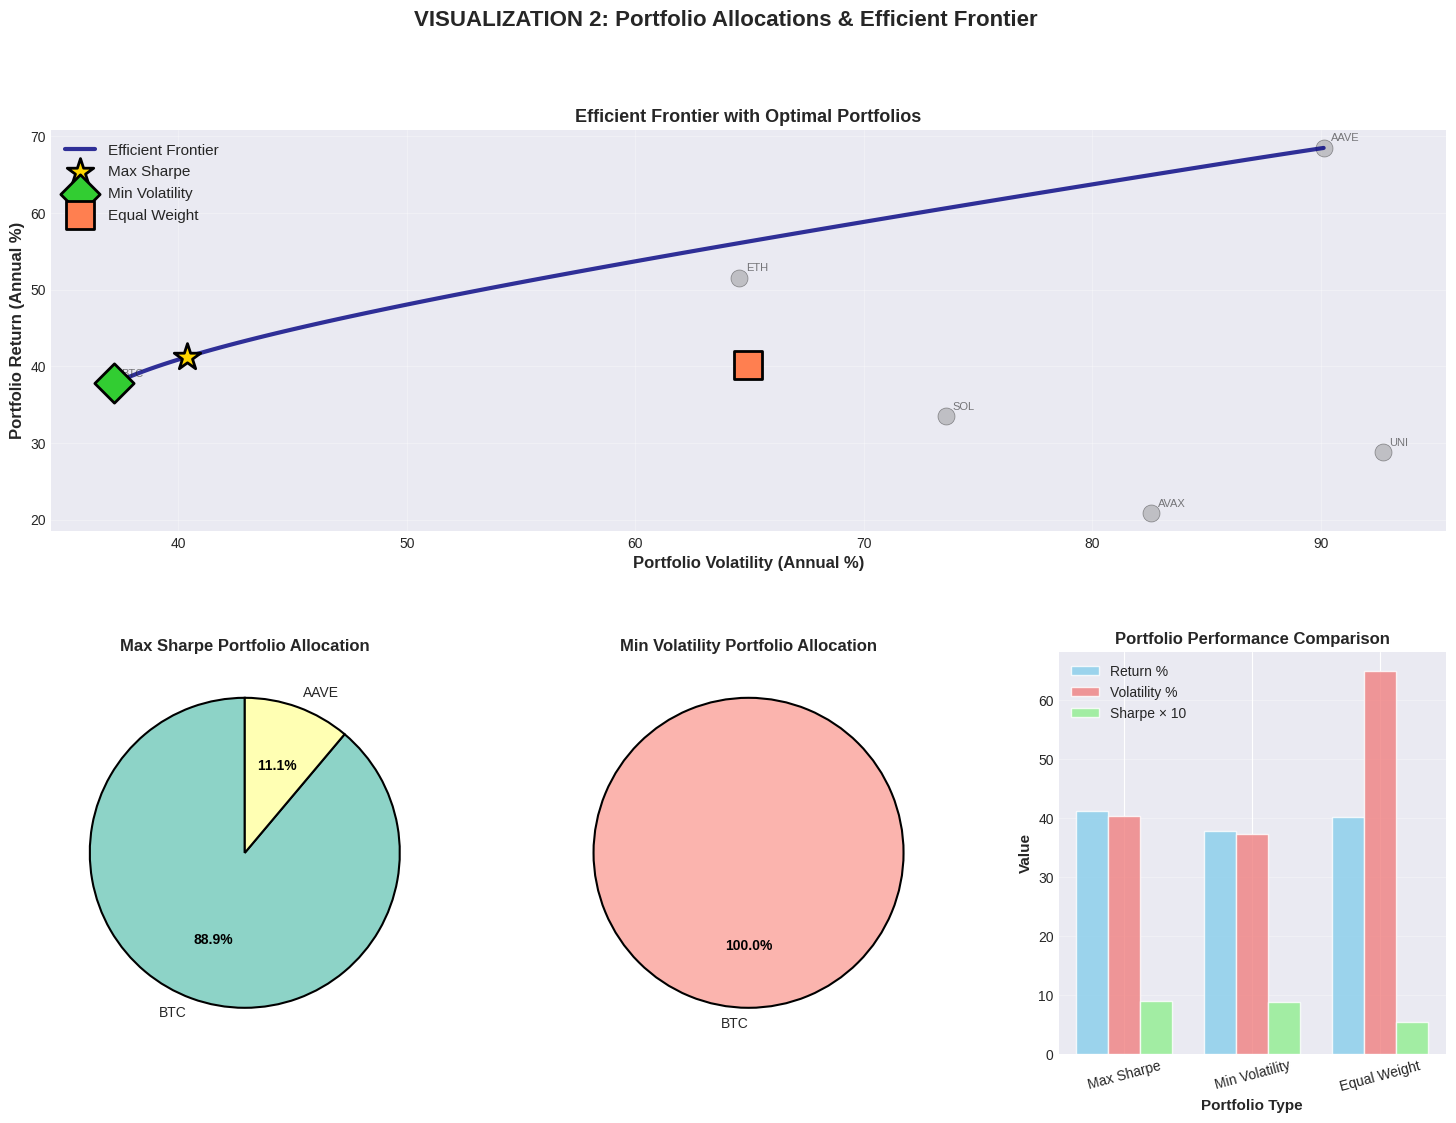


✅ Visualization 2 complete: 4 charts showing portfolio allocations


In [27]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('VISUALIZATION 2: Portfolio Allocations & Efficient Frontier', 
             fontsize=16, fontweight='bold', y=0.98)

# Chart 1: Efficient Frontier with optimal portfolios
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(efficient_frontier['volatility']*100, 
        efficient_frontier['return']*100,
        linewidth=3, color='navy', label='Efficient Frontier', alpha=0.8)

# Plot optimal portfolios
ax1.scatter(max_sharpe_portfolio['volatility']*100, 
           max_sharpe_portfolio['return']*100,
           s=400, marker='*', color='gold', edgecolors='black', 
           linewidth=2, label='Max Sharpe', zorder=5)

ax1.scatter(min_vol_portfolio['volatility']*100, 
           min_vol_portfolio['return']*100,
           s=400, marker='D', color='limegreen', edgecolors='black',
           linewidth=2, label='Min Volatility', zorder=5)

ax1.scatter(equal_weight_portfolio['volatility']*100, 
           equal_weight_portfolio['return']*100,
           s=400, marker='s', color='coral', edgecolors='black',
           linewidth=2, label='Equal Weight', zorder=5)

# Plot individual assets
for idx, row in asset_statistics.iterrows():
    ax1.scatter(row['Volatility_%'], row['Annual_Return_%'],
               s=150, alpha=0.4, color='gray', edgecolors='black', linewidth=0.5)
    ax1.annotate(row['Asset'], 
                (row['Volatility_%'], row['Annual_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.6)

ax1.set_xlabel('Portfolio Volatility (Annual %)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Portfolio Return (Annual %)', fontsize=12, fontweight='bold')
ax1.set_title('Efficient Frontier with Optimal Portfolios', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Chart 2: Max Sharpe allocation pie chart
ax2 = fig.add_subplot(gs[1, 0])
max_sharpe_data = portfolio_allocations_filtered[['Asset', 'Max_Sharpe_%']].copy()
max_sharpe_data = max_sharpe_data[max_sharpe_data['Max_Sharpe_%'] >= 1]
colors_sharpe = sns.color_palette('Set3', len(max_sharpe_data))
wedges, texts, autotexts = ax2.pie(max_sharpe_data['Max_Sharpe_%'], 
                                    labels=max_sharpe_data['Asset'],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors_sharpe,
                                    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)
ax2.set_title('Max Sharpe Portfolio Allocation', fontsize=12, fontweight='bold')

# Chart 3: Min Volatility allocation pie chart
ax3 = fig.add_subplot(gs[1, 1])
min_vol_data = portfolio_allocations_filtered[['Asset', 'Min_Volatility_%']].copy()
min_vol_data = min_vol_data[min_vol_data['Min_Volatility_%'] >= 1]
colors_minvol = sns.color_palette('Pastel1', len(min_vol_data))
wedges, texts, autotexts = ax3.pie(min_vol_data['Min_Volatility_%'], 
                                    labels=min_vol_data['Asset'],
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors_minvol,
                                    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)
ax3.set_title('Min Volatility Portfolio Allocation', fontsize=12, fontweight='bold')

# Chart 4: Comparison bar chart
ax4 = fig.add_subplot(gs[1, 2])
comparison_data = pd.DataFrame({
    'Portfolio': ['Max Sharpe', 'Min Volatility', 'Equal Weight'],
    'Return_%': [
        max_sharpe_portfolio['return']*100,
        min_vol_portfolio['return']*100,
        equal_weight_portfolio['return']*100
    ],
    'Volatility_%': [
        max_sharpe_portfolio['volatility']*100,
        min_vol_portfolio['volatility']*100,
        equal_weight_portfolio['volatility']*100
    ],
    'Sharpe': [
        max_sharpe_portfolio['sharpe'],
        min_vol_portfolio['sharpe'],
        equal_weight_portfolio['sharpe']
    ]
})

x_pos = np.arange(len(comparison_data))
width = 0.25

bars1 = ax4.bar(x_pos - width, comparison_data['Return_%'], 
               width, label='Return %', alpha=0.8, color='skyblue')
bars2 = ax4.bar(x_pos, comparison_data['Volatility_%'], 
               width, label='Volatility %', alpha=0.8, color='lightcoral')
bars3 = ax4.bar(x_pos + width, comparison_data['Sharpe']*10, 
               width, label='Sharpe × 10', alpha=0.8, color='lightgreen')

ax4.set_xlabel('Portfolio Type', fontsize=11, fontweight='bold')
ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
ax4.set_title('Portfolio Performance Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_data['Portfolio'], rotation=15)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.show()

print("\n✅ Visualization 2 complete: 4 charts showing portfolio allocations")

---
## 9. Monte Carlo Simulation

In [28]:
def monte_carlo_portfolio_simulation(weights: np.ndarray,
                                    mean_returns: np.ndarray,
                                    cov_matrix: np.ndarray,
                                    initial_investment: float = 10000,
                                    num_days: int = 252,
                                    num_simulations: int = 10000) -> np.ndarray:
    """
    Run Monte Carlo simulation for portfolio value over time.
    
    Args:
        weights: Portfolio weights
        mean_returns: Daily mean returns (annualized / 252)
        cov_matrix: Covariance matrix (annualized / 252)
        initial_investment: Starting capital
        num_days: Simulation horizon in trading days
        num_simulations: Number of Monte Carlo runs
    
    Returns:
        Array of shape (num_simulations, num_days) with portfolio values
    """
    # Convert annualized to daily
    daily_returns = mean_returns / 252
    daily_cov = cov_matrix / 252
    
    # Calculate portfolio daily return and volatility
    port_return = np.dot(weights, daily_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(daily_cov, weights)))
    
    # Generate random returns
    simulated_returns = np.random.normal(
        port_return, 
        port_std, 
        size=(num_simulations, num_days)
    )
    
    # Calculate cumulative portfolio values
    portfolio_values = initial_investment * np.cumprod(1 + simulated_returns, axis=1)
    
    return portfolio_values

print("Running Monte Carlo simulations (10,000 runs)...\n")

# Simulate Max Sharpe portfolio
print("1️⃣ Simulating Max Sharpe Portfolio...")
mc_max_sharpe = monte_carlo_portfolio_simulation(
    max_sharpe_portfolio['weights'],
    mean_returns,
    cov_matrix,
    initial_investment=10000,
    num_days=252,
    num_simulations=10000
)
print(f"   ✅ {mc_max_sharpe.shape[0]} simulations complete\n")

# Simulate Min Volatility portfolio
print("2️⃣ Simulating Min Volatility Portfolio...")
mc_min_vol = monte_carlo_portfolio_simulation(
    min_vol_portfolio['weights'],
    mean_returns,
    cov_matrix,
    initial_investment=10000,
    num_days=252,
    num_simulations=10000
)
print(f"   ✅ {mc_min_vol.shape[0]} simulations complete\n")

# Simulate Equal Weight portfolio
print("3️⃣ Simulating Equal Weight Portfolio...")
mc_equal_weight = monte_carlo_portfolio_simulation(
    equal_weight_portfolio['weights'],
    mean_returns,
    cov_matrix,
    initial_investment=10000,
    num_days=252,
    num_simulations=10000
)
print(f"   ✅ {mc_equal_weight.shape[0]} simulations complete\n")

Running Monte Carlo simulations (10,000 runs)...

1️⃣ Simulating Max Sharpe Portfolio...
   ✅ 10000 simulations complete

2️⃣ Simulating Min Volatility Portfolio...
   ✅ 10000 simulations complete

3️⃣ Simulating Equal Weight Portfolio...
   ✅ 10000 simulations complete



In [29]:
# Calculate Monte Carlo statistics
def calculate_mc_statistics(mc_results: np.ndarray, 
                           initial_investment: float = 10000) -> Dict:
    """
    Calculate statistics from Monte Carlo simulation results.
    """
    final_values = mc_results[:, -1]
    
    returns = (final_values - initial_investment) / initial_investment * 100
    
    return {
        'mean_final_value': final_values.mean(),
        'median_final_value': np.median(final_values),
        'min_final_value': final_values.min(),
        'max_final_value': final_values.max(),
        'std_final_value': final_values.std(),
        'percentile_5': np.percentile(final_values, 5),
        'percentile_25': np.percentile(final_values, 25),
        'percentile_75': np.percentile(final_values, 75),
        'percentile_95': np.percentile(final_values, 95),
        'probability_profit': (returns > 0).sum() / len(returns) * 100,
        'probability_loss': (returns < 0).sum() / len(returns) * 100
    }

mc_stats_max_sharpe = calculate_mc_statistics(mc_max_sharpe)
mc_stats_min_vol = calculate_mc_statistics(mc_min_vol)
mc_stats_equal = calculate_mc_statistics(mc_equal_weight)

print("\n📊 Monte Carlo Simulation Statistics (1 Year, $10,000 initial):")
print("\nMax Sharpe Portfolio:")
print(f"  Mean Final Value: ${mc_stats_max_sharpe['mean_final_value']:,.0f}")
print(f"  Median Final Value: ${mc_stats_max_sharpe['median_final_value']:,.0f}")
print(f"  5th Percentile: ${mc_stats_max_sharpe['percentile_5']:,.0f}")
print(f"  95th Percentile: ${mc_stats_max_sharpe['percentile_95']:,.0f}")
print(f"  Probability of Profit: {mc_stats_max_sharpe['probability_profit']:.1f}%")

print("\nMin Volatility Portfolio:")
print(f"  Mean Final Value: ${mc_stats_min_vol['mean_final_value']:,.0f}")
print(f"  Median Final Value: ${mc_stats_min_vol['median_final_value']:,.0f}")
print(f"  5th Percentile: ${mc_stats_min_vol['percentile_5']:,.0f}")
print(f"  95th Percentile: ${mc_stats_min_vol['percentile_95']:,.0f}")
print(f"  Probability of Profit: {mc_stats_min_vol['probability_profit']:.1f}%")

print("\nEqual Weight Portfolio:")
print(f"  Mean Final Value: ${mc_stats_equal['mean_final_value']:,.0f}")
print(f"  Median Final Value: ${mc_stats_equal['median_final_value']:,.0f}")
print(f"  5th Percentile: ${mc_stats_equal['percentile_5']:,.0f}")
print(f"  95th Percentile: ${mc_stats_equal['percentile_95']:,.0f}")
print(f"  Probability of Profit: {mc_stats_equal['probability_profit']:.1f}%")


📊 Monte Carlo Simulation Statistics (1 Year, $10,000 initial):

Max Sharpe Portfolio:
  Mean Final Value: $15,021
  Median Final Value: $13,879
  5th Percentile: $7,095
  95th Percentile: $26,666
  Probability of Profit: 79.3%

Min Volatility Portfolio:
  Mean Final Value: $14,583
  Median Final Value: $13,615
  5th Percentile: $7,446
  95th Percentile: $25,191
  Probability of Profit: 80.2%

Equal Weight Portfolio:
  Mean Final Value: $14,956
  Median Final Value: $12,260
  5th Percentile: $4,071
  95th Percentile: $34,740
  Probability of Profit: 62.1%


---
## 10. VISUALIZATION GROUP 3: Monte Carlo Simulations
### 4 charts showing simulation results

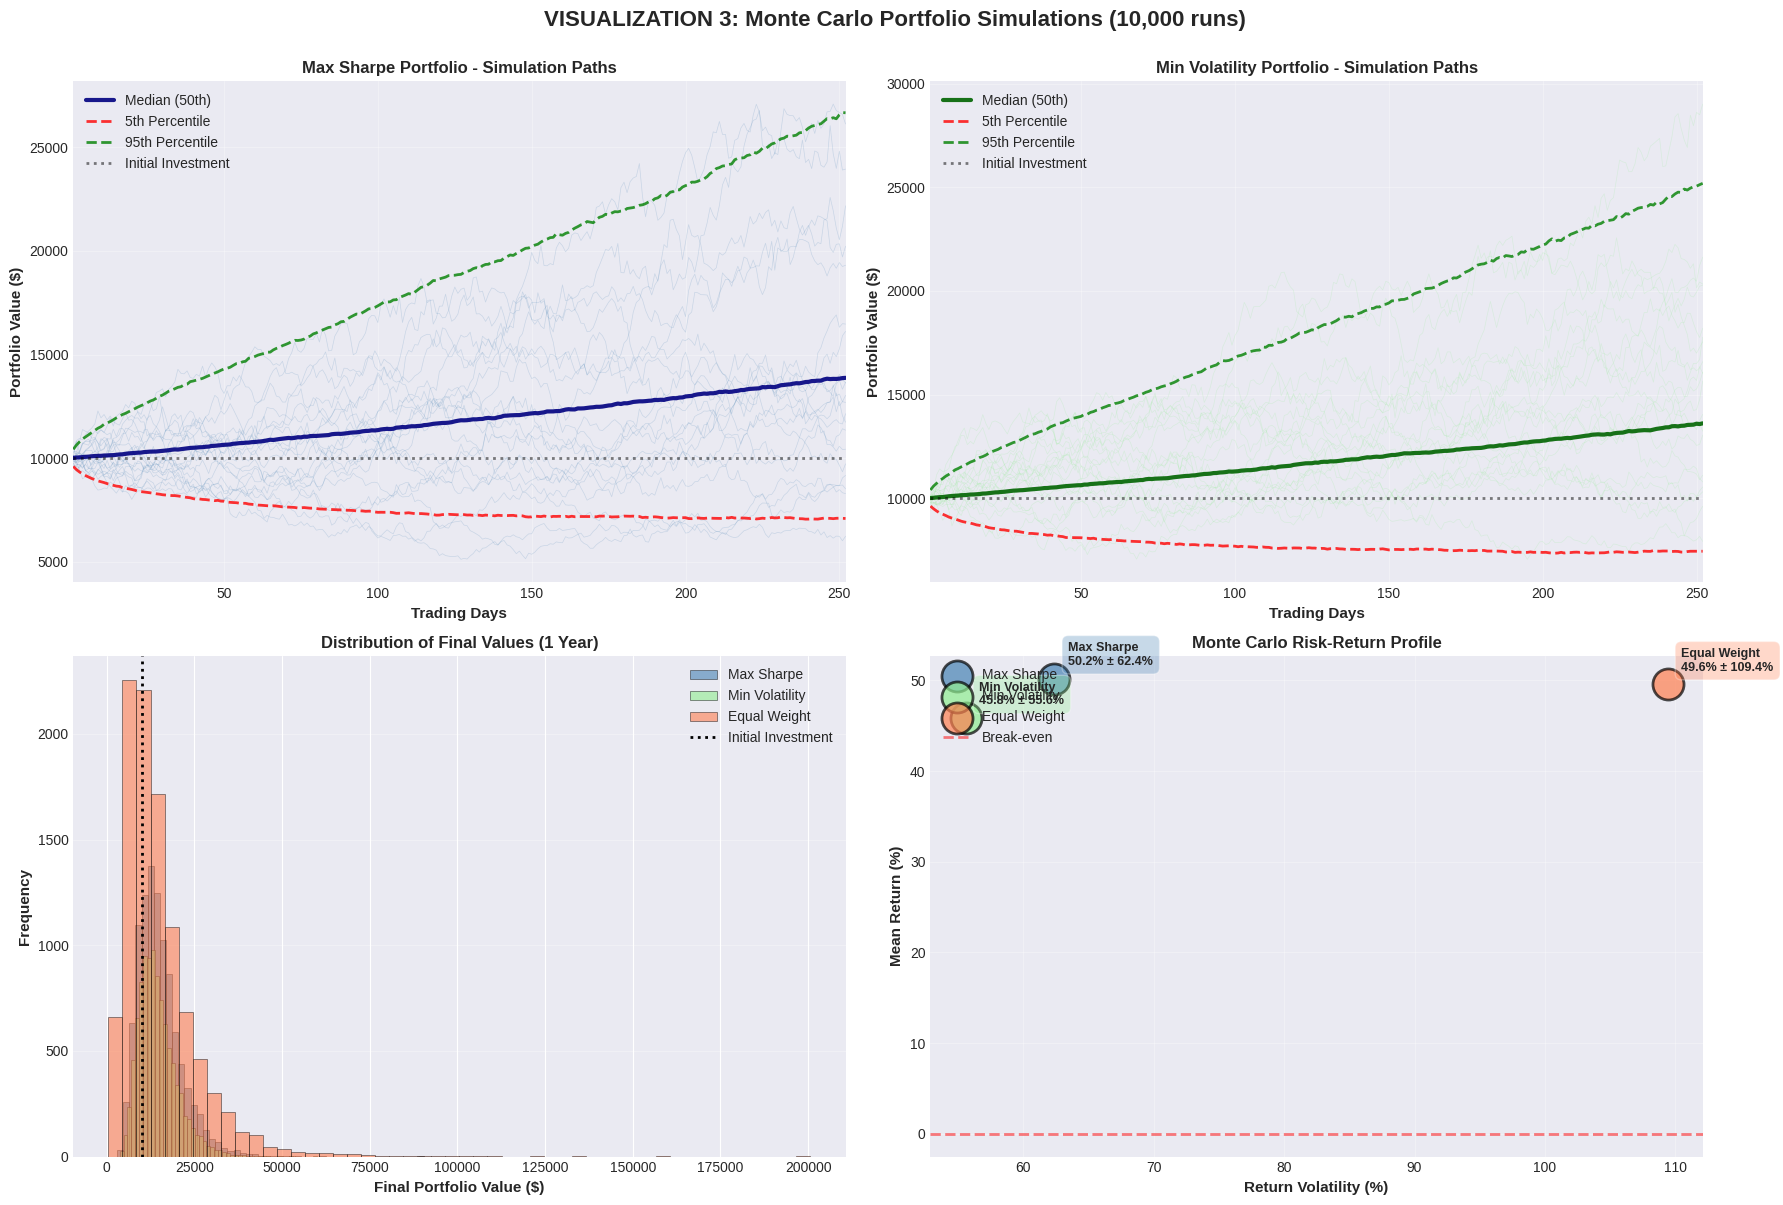


✅ Visualization 3 complete: 4 charts showing Monte Carlo simulations


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('VISUALIZATION 3: Monte Carlo Portfolio Simulations (10,000 runs)', 
             fontsize=16, fontweight='bold', y=1.00)

days_axis = np.arange(1, mc_max_sharpe.shape[1] + 1)

# Chart 1: Max Sharpe simulation paths
ax1 = axes[0, 0]
# Plot sample paths
for i in range(0, 200, 10):  # Plot 20 sample paths
    ax1.plot(days_axis, mc_max_sharpe[i, :], alpha=0.2, linewidth=0.5, color='steelblue')

# Plot percentiles
ax1.plot(days_axis, np.percentile(mc_max_sharpe, 50, axis=0), 
        linewidth=3, color='navy', label='Median (50th)', alpha=0.9)
ax1.plot(days_axis, np.percentile(mc_max_sharpe, 5, axis=0), 
        linewidth=2, color='red', linestyle='--', label='5th Percentile', alpha=0.8)
ax1.plot(days_axis, np.percentile(mc_max_sharpe, 95, axis=0), 
        linewidth=2, color='green', linestyle='--', label='95th Percentile', alpha=0.8)
ax1.axhline(y=10000, color='black', linestyle=':', linewidth=2, alpha=0.5, label='Initial Investment')

ax1.set_xlabel('Trading Days', fontsize=11, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
ax1.set_title('Max Sharpe Portfolio - Simulation Paths', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 252)

# Chart 2: Min Volatility simulation paths
ax2 = axes[0, 1]
for i in range(0, 200, 10):
    ax2.plot(days_axis, mc_min_vol[i, :], alpha=0.2, linewidth=0.5, color='lightgreen')

ax2.plot(days_axis, np.percentile(mc_min_vol, 50, axis=0), 
        linewidth=3, color='darkgreen', label='Median (50th)', alpha=0.9)
ax2.plot(days_axis, np.percentile(mc_min_vol, 5, axis=0), 
        linewidth=2, color='red', linestyle='--', label='5th Percentile', alpha=0.8)
ax2.plot(days_axis, np.percentile(mc_min_vol, 95, axis=0), 
        linewidth=2, color='green', linestyle='--', label='95th Percentile', alpha=0.8)
ax2.axhline(y=10000, color='black', linestyle=':', linewidth=2, alpha=0.5, label='Initial Investment')

ax2.set_xlabel('Trading Days', fontsize=11, fontweight='bold')
ax2.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
ax2.set_title('Min Volatility Portfolio - Simulation Paths', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 252)

# Chart 3: Distribution of final values
ax3 = axes[1, 0]
bins = 50
ax3.hist(mc_max_sharpe[:, -1], bins=bins, alpha=0.6, 
        label='Max Sharpe', color='steelblue', edgecolor='black', linewidth=0.5)
ax3.hist(mc_min_vol[:, -1], bins=bins, alpha=0.6, 
        label='Min Volatility', color='lightgreen', edgecolor='black', linewidth=0.5)
ax3.hist(mc_equal_weight[:, -1], bins=bins, alpha=0.6, 
        label='Equal Weight', color='coral', edgecolor='black', linewidth=0.5)
ax3.axvline(x=10000, color='black', linestyle=':', linewidth=2, label='Initial Investment')

ax3.set_xlabel('Final Portfolio Value ($)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Final Values (1 Year)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Chart 4: Risk vs Return comparison
ax4 = axes[1, 1]
portfolio_names = ['Max Sharpe', 'Min Volatility', 'Equal Weight']
mc_results = [mc_max_sharpe, mc_min_vol, mc_equal_weight]
colors = ['steelblue', 'lightgreen', 'coral']

for name, mc_data, color in zip(portfolio_names, mc_results, colors):
    final_returns = (mc_data[:, -1] - 10000) / 10000 * 100
    mean_return = final_returns.mean()
    std_return = final_returns.std()
    
    ax4.scatter(std_return, mean_return, s=500, alpha=0.7, 
               color=color, edgecolors='black', linewidth=2, label=name)
    
    ax4.annotate(f"{name}\n{mean_return:.1f}% ± {std_return:.1f}%",
                (std_return, mean_return),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.3))

ax4.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Break-even')
ax4.set_xlabel('Return Volatility (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Mean Return (%)', fontsize=11, fontweight='bold')
ax4.set_title('Monte Carlo Risk-Return Profile', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization 3 complete: 4 charts showing Monte Carlo simulations")

---
## 11. Rebalancing Strategy Analysis

In [31]:
def simulate_rebalancing_strategy(target_weights: np.ndarray,
                                 price_data_df: pd.DataFrame,
                                 asset_cols: List[str],
                                 rebalance_threshold: float = 0.05,
                                 initial_investment: float = 10000) -> pd.DataFrame:
    """
    Simulate portfolio with threshold-based rebalancing.
    
    Args:
        target_weights: Target portfolio weights
        price_data_df: Historical price data
        asset_cols: List of asset column names
        rebalance_threshold: Trigger rebalancing if weight drifts > threshold
        initial_investment: Starting capital
    
    Returns:
        DataFrame with portfolio value, weights, and rebalancing events
    """
    results = []
    
    # Initial allocation
    current_holdings = target_weights * initial_investment
    initial_prices = price_data_df[asset_cols].iloc[0].values
    shares = current_holdings / initial_prices
    
    rebalance_dates = []
    rebalance_costs = []
    
    for idx, row in price_data_df.iterrows():
        current_prices = row[asset_cols].values
        current_values = shares * current_prices
        portfolio_value = current_values.sum()
        current_weights = current_values / portfolio_value
        
        # Check if rebalancing needed
        weight_drift = np.abs(current_weights - target_weights)
        needs_rebalancing = np.any(weight_drift > rebalance_threshold)
        
        if needs_rebalancing and idx > 0:
            # Rebalance to target weights
            target_values = target_weights * portfolio_value
            trade_amounts = np.abs(target_values - current_values)
            transaction_cost = trade_amounts.sum() * 0.001  # 0.1% trading fee
            
            shares = (target_values - transaction_cost * target_weights) / current_prices
            portfolio_value -= transaction_cost
            current_weights = target_weights.copy()
            
            rebalance_dates.append(row['date'])
            rebalance_costs.append(transaction_cost)
        
        results.append({
            'date': row['date'],
            'portfolio_value': portfolio_value,
            'rebalanced': needs_rebalancing and idx > 0,
            **{f'weight_{asset}': w for asset, w in zip(asset_cols, current_weights)}
        })
    
    results_df = pd.DataFrame(results)
    results_df['cumulative_return_%'] = (results_df['portfolio_value'] / initial_investment - 1) * 100
    
    return results_df, rebalance_dates, rebalance_costs

print("Simulating rebalancing strategies...\n")

# Simulate different rebalancing thresholds
print("1️⃣ Max Sharpe Portfolio with 5% threshold...")
rebal_5pct, rebal_dates_5, costs_5 = simulate_rebalancing_strategy(
    max_sharpe_portfolio['weights'],
    price_data,
    asset_columns,
    rebalance_threshold=0.05
)
print(f"   ✅ {len(rebal_dates_5)} rebalancing events")
print(f"   Total transaction costs: ${sum(costs_5):.2f}\n")

print("2️⃣ Max Sharpe Portfolio with 10% threshold...")
rebal_10pct, rebal_dates_10, costs_10 = simulate_rebalancing_strategy(
    max_sharpe_portfolio['weights'],
    price_data,
    asset_columns,
    rebalance_threshold=0.10
)
print(f"   ✅ {len(rebal_dates_10)} rebalancing events")
print(f"   Total transaction costs: ${sum(costs_10):.2f}\n")

print("3️⃣ Max Sharpe Portfolio with NO rebalancing...")
rebal_never, _, _ = simulate_rebalancing_strategy(
    max_sharpe_portfolio['weights'],
    price_data,
    asset_columns,
    rebalance_threshold=1.0  # Never triggers
)
print(f"   ✅ Buy and hold strategy (no rebalancing)\n")

Simulating rebalancing strategies...

1️⃣ Max Sharpe Portfolio with 5% threshold...
   ✅ 3 rebalancing events
   Total transaction costs: $5.42

2️⃣ Max Sharpe Portfolio with 10% threshold...
   ✅ 0 rebalancing events
   Total transaction costs: $0.00

3️⃣ Max Sharpe Portfolio with NO rebalancing...
   ✅ Buy and hold strategy (no rebalancing)



---
## 12. VISUALIZATION GROUP 4: Rebalancing Strategies
### 3 charts showing rebalancing impact

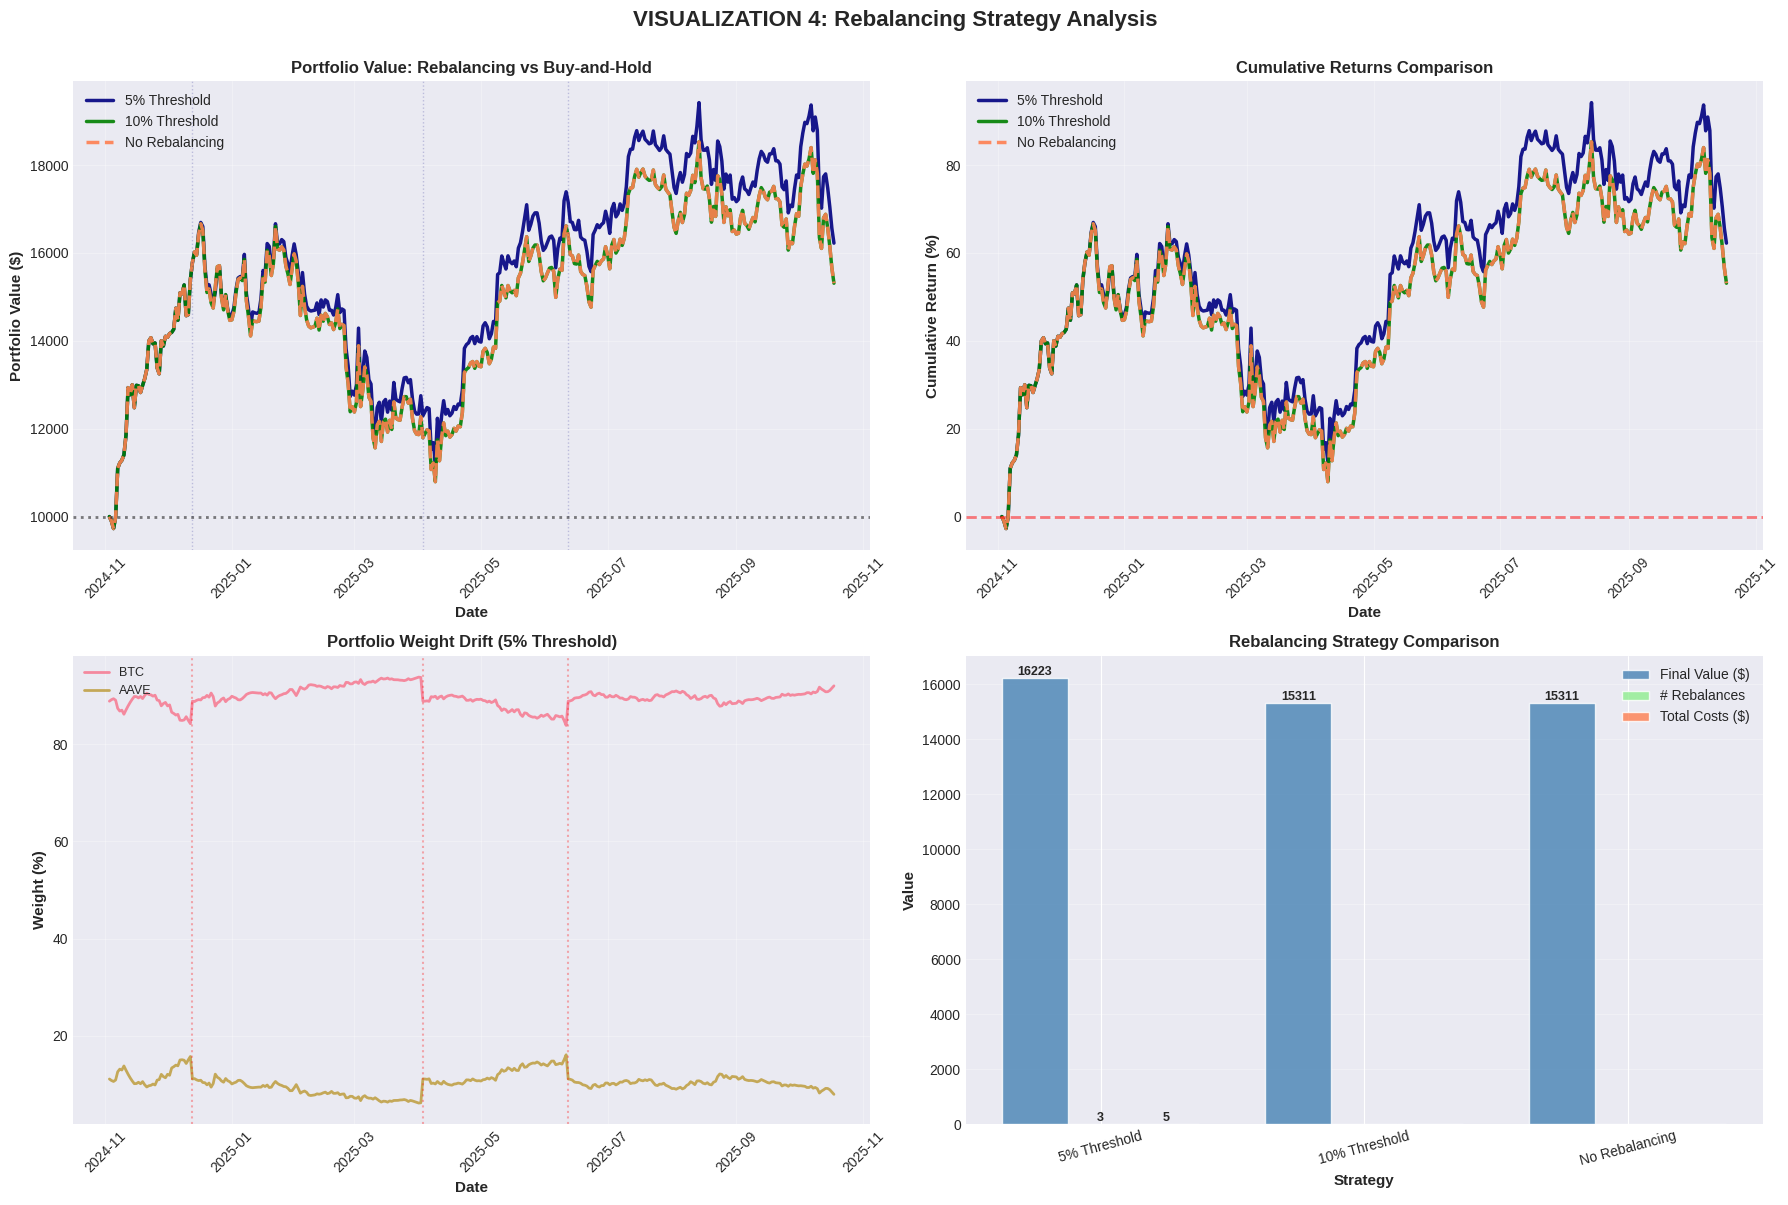


✅ Visualization 4 complete: 4 charts showing rebalancing strategies


In [32]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('VISUALIZATION 4: Rebalancing Strategy Analysis', 
             fontsize=16, fontweight='bold', y=1.00)

# Chart 1: Portfolio value comparison
ax1 = axes[0, 0]
ax1.plot(rebal_5pct['date'], rebal_5pct['portfolio_value'], 
        linewidth=2.5, label='5% Threshold', alpha=0.9, color='navy')
ax1.plot(rebal_10pct['date'], rebal_10pct['portfolio_value'], 
        linewidth=2.5, label='10% Threshold', alpha=0.9, color='green')
ax1.plot(rebal_never['date'], rebal_never['portfolio_value'], 
        linewidth=2.5, label='No Rebalancing', alpha=0.9, color='coral', linestyle='--')

# Mark rebalancing events
for rebal_date in rebal_dates_5:
    ax1.axvline(x=rebal_date, color='navy', alpha=0.2, linewidth=1, linestyle=':')

ax1.axhline(y=10000, color='black', linestyle=':', linewidth=2, alpha=0.5)
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=11, fontweight='bold')
ax1.set_title('Portfolio Value: Rebalancing vs Buy-and-Hold', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Chart 2: Cumulative returns
ax2 = axes[0, 1]
ax2.plot(rebal_5pct['date'], rebal_5pct['cumulative_return_%'], 
        linewidth=2.5, label='5% Threshold', alpha=0.9, color='navy')
ax2.plot(rebal_10pct['date'], rebal_10pct['cumulative_return_%'], 
        linewidth=2.5, label='10% Threshold', alpha=0.9, color='green')
ax2.plot(rebal_never['date'], rebal_never['cumulative_return_%'], 
        linewidth=2.5, label='No Rebalancing', alpha=0.9, color='coral', linestyle='--')

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Chart 3: Weight drift over time (5% threshold)
ax3 = axes[1, 0]
for i, asset in enumerate(asset_columns):
    if max_sharpe_portfolio['weights'][i] > 0.01:  # Only plot assets with >1% target
        ax3.plot(rebal_5pct['date'], rebal_5pct[f'weight_{asset}'] * 100,
                linewidth=2, label=asset, alpha=0.8)

# Mark rebalancing events
for rebal_date in rebal_dates_5:
    ax3.axvline(x=rebal_date, color='red', alpha=0.3, linewidth=1.5, linestyle=':')

ax3.set_xlabel('Date', fontsize=11, fontweight='bold')
ax3.set_ylabel('Weight (%)', fontsize=11, fontweight='bold')
ax3.set_title('Portfolio Weight Drift (5% Threshold)', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Chart 4: Rebalancing statistics
ax4 = axes[1, 1]
strategies = ['5% Threshold', '10% Threshold', 'No Rebalancing']
final_values = [
    rebal_5pct['portfolio_value'].iloc[-1],
    rebal_10pct['portfolio_value'].iloc[-1],
    rebal_never['portfolio_value'].iloc[-1]
]
num_rebalances = [len(rebal_dates_5), len(rebal_dates_10), 0]
total_costs = [sum(costs_5), sum(costs_10), 0]

x_pos = np.arange(len(strategies))
width = 0.25

bars1 = ax4.bar(x_pos - width, final_values, width, 
               label='Final Value ($)', alpha=0.8, color='steelblue')
bars2 = ax4.bar(x_pos, num_rebalances, width, 
               label='# Rebalances', alpha=0.8, color='lightgreen')
bars3 = ax4.bar(x_pos + width, total_costs, width, 
               label='Total Costs ($)', alpha=0.8, color='coral')

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.0f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax4.set_xlabel('Strategy', fontsize=11, fontweight='bold')
ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
ax4.set_title('Rebalancing Strategy Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(strategies, rotation=15)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Visualization 4 complete: 4 charts showing rebalancing strategies")

---
## 13. Summary & Key Takeaways

In [33]:
print("="*80)
print("📊 PORTFOLIO OPTIMIZATION SUMMARY")
print("="*80)

print("\n1️⃣ OPTIMAL PORTFOLIOS:")
print("\n   Max Sharpe Ratio Portfolio:")
print(f"     • Expected Return: {max_sharpe_portfolio['return']*100:.2f}%")
print(f"     • Volatility: {max_sharpe_portfolio['volatility']*100:.2f}%")
print(f"     • Sharpe Ratio: {max_sharpe_portfolio['sharpe']:.3f}")
print(f"     • Top Holdings:")
top_holdings_sharpe = portfolio_allocations.nlargest(3, 'Max_Sharpe_%')[['Asset', 'Max_Sharpe_%']]
for _, row in top_holdings_sharpe.iterrows():
    print(f"       - {row['Asset']}: {row['Max_Sharpe_%']:.1f}%")

print("\n   Minimum Volatility Portfolio:")
print(f"     • Expected Return: {min_vol_portfolio['return']*100:.2f}%")
print(f"     • Volatility: {min_vol_portfolio['volatility']*100:.2f}%")
print(f"     • Sharpe Ratio: {min_vol_portfolio['sharpe']:.3f}")
print(f"     • Top Holdings:")
top_holdings_minvol = portfolio_allocations.nlargest(3, 'Min_Volatility_%')[['Asset', 'Min_Volatility_%']]
for _, row in top_holdings_minvol.iterrows():
    print(f"       - {row['Asset']}: {row['Min_Volatility_%']:.1f}%")

print("\n2️⃣ MONTE CARLO INSIGHTS (10,000 simulations, 1 year):")
print(f"\n   Max Sharpe Portfolio:")
print(f"     • Expected Value: ${mc_stats_max_sharpe['mean_final_value']:,.0f}")
print(f"     • 90% Confidence: ${mc_stats_max_sharpe['percentile_5']:,.0f} - ${mc_stats_max_sharpe['percentile_95']:,.0f}")
print(f"     • Probability of Profit: {mc_stats_max_sharpe['probability_profit']:.1f}%")

print(f"\n   Min Volatility Portfolio:")
print(f"     • Expected Value: ${mc_stats_min_vol['mean_final_value']:,.0f}")
print(f"     • 90% Confidence: ${mc_stats_min_vol['percentile_5']:,.0f} - ${mc_stats_min_vol['percentile_95']:,.0f}")
print(f"     • Probability of Profit: {mc_stats_min_vol['probability_profit']:.1f}%")

print("\n3️⃣ REBALANCING RECOMMENDATIONS:")
print(f"\n   5% Threshold Strategy:")
print(f"     • Final Value: ${rebal_5pct['portfolio_value'].iloc[-1]:,.0f}")
print(f"     • Number of Rebalances: {len(rebal_dates_5)}")
print(f"     • Total Transaction Costs: ${sum(costs_5):.2f}")
print(f"     • Final Return: {rebal_5pct['cumulative_return_%'].iloc[-1]:.2f}%")

print(f"\n   10% Threshold Strategy:")
print(f"     • Final Value: ${rebal_10pct['portfolio_value'].iloc[-1]:,.0f}")
print(f"     • Number of Rebalances: {len(rebal_dates_10)}")
print(f"     • Total Transaction Costs: ${sum(costs_10):.2f}")
print(f"     • Final Return: {rebal_10pct['cumulative_return_%'].iloc[-1]:.2f}%")

print("\n4️⃣ KEY TAKEAWAYS:")
print("\n   ✅ Diversification reduces portfolio volatility")
print("   ✅ Sharpe ratio optimization balances risk and return")
print("   ✅ Rebalancing maintains target allocation")
print("   ✅ Transaction costs can erode returns")
print("   ✅ Monte Carlo simulations quantify uncertainty")
print("   ✅ Risk metrics (VaR, CVaR) measure tail risk")

print("\n" + "="*80)
print("📝 HOMEWORK ASSIGNMENT:")
print("="*80)
print("\n1. Create your own portfolio with 3-5 crypto assets")
print("2. Optimize for maximum Sharpe ratio")
print("3. Run Monte Carlo simulation (1,000+ runs)")
print("4. Calculate VaR and CVaR at 95% confidence")
print("5. Compare your portfolio to equal-weight benchmark")
print("6. Document your findings and risk assessment")
print("\n" + "="*80)

print("\n✅ Notebook D complete: Portfolio Optimization with 15+ visualizations")

📊 PORTFOLIO OPTIMIZATION SUMMARY

1️⃣ OPTIMAL PORTFOLIOS:

   Max Sharpe Ratio Portfolio:
     • Expected Return: 41.19%
     • Volatility: 40.36%
     • Sharpe Ratio: 0.897
     • Top Holdings:
       - BTC: 88.9%
       - AAVE: 11.1%
       - ETH: 0.0%

   Minimum Volatility Portfolio:
     • Expected Return: 37.77%
     • Volatility: 37.20%
     • Sharpe Ratio: 0.881
     • Top Holdings:
       - BTC: 100.0%
       - ETH: 0.0%
       - AAVE: 0.0%

2️⃣ MONTE CARLO INSIGHTS (10,000 simulations, 1 year):

   Max Sharpe Portfolio:
     • Expected Value: $15,021
     • 90% Confidence: $7,095 - $26,666
     • Probability of Profit: 79.3%

   Min Volatility Portfolio:
     • Expected Value: $14,583
     • 90% Confidence: $7,446 - $25,191
     • Probability of Profit: 80.2%

3️⃣ REBALANCING RECOMMENDATIONS:

   5% Threshold Strategy:
     • Final Value: $16,223
     • Number of Rebalances: 3
     • Total Transaction Costs: $5.42
     • Final Return: 62.23%

   10% Threshold Strategy:
     •